<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/FB_Prophet_Store_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6751484 sha256=1b64cb5597a34b3061a21706bb258f7dab580f8c143600dc4217b9834160d77d
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdsta

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet

import warnings
warnings.simplefilter("ignore")

In [3]:
data_train = pd.read_csv('https://github.com/MpRonald/datasets/blob/main/store_train.csv?raw=true')
data_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
data_train.shape

(1017209, 9)

In [5]:
data_train.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [6]:
data_train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [7]:
data_train.Promo.value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [9]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


In [10]:
data_store = pd.read_csv('https://github.com/MpRonald/datasets/raw/main/store.csv')
data_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
data_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
data_store.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1115.0,558.000000,322.017080,1.0,279.5,558.0,836.5,1115.0
CompetitionDistance,1112.0,5404.901079,7663.174720,20.0,717.5,2325.0,6882.5,75860.0
CompetitionOpenSinceMonth,761.0,7.224704,3.212348,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,761.0,2008.668857,6.195983,1900.0,2006.0,2010.0,2013.0,2015.0
Promo2,1115.0,0.512108,0.500078,0.0,0.0,1.0,1.0,1.0
Promo2SinceWeek,571.0,23.595447,14.141984,1.0,13.0,22.0,37.0,50.0
Promo2SinceYear,571.0,2011.763573,1.674935,2009.0,2011.0,2012.0,2013.0,2015.0


In [13]:
print(f"Null data: \n{data_train.isnull().sum()}\n")
print(f"Duplicated data:{data_train.duplicated().sum()}")

Null data: 
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Duplicated data:0


In [14]:
data_closed_train = data_train[data_train['Open'] == 0]
data_open_train = data_train[data_train['Open'] == 1]

In [15]:
print('*-*-*-TOTAL-*-*-*')
print(f"Total days closed: {round(len(data_closed_train) / len(data_store),0)}")
print(f"Total days open: {round(len(data_open_train) / len(data_store),0)}")

*-*-*-TOTAL-*-*-*
Total days closed: 155.0
Total days open: 757.0


In [16]:
data_open_train.shape

(844392, 9)

In [17]:
data_open_train.drop(['Open'], axis=1, inplace=True)
data_open_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [18]:
data_open_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844392 non-null  int64 
 1   DayOfWeek      844392 non-null  int64 
 2   Date           844392 non-null  object
 3   Sales          844392 non-null  int64 
 4   Customers      844392 non-null  int64 
 5   Promo          844392 non-null  int64 
 6   StateHoliday   844392 non-null  object
 7   SchoolHoliday  844392 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 58.0+ MB


In [19]:
data_open_train[['Sales', 'Customers']].describe()

,Sales,Customers
count,844392.000000,844392.000000
mean,6955.514291,762.728395
std,3104.214680,401.227674
min,0.000000,0.000000
25%,4859.000000,519.000000
50%,6369.000000,676.000000
75%,8360.000000,893.000000
max,41551.000000,7388.000000


In [20]:
data_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
data_store.CompetitionDistance.describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

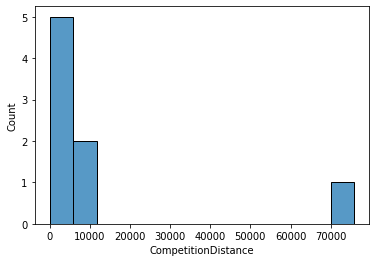

In [22]:
sns.histplot(data_store.CompetitionDistance.describe());

In [23]:
data_store.CompetitionDistance.fillna(data_store.CompetitionDistance.median(), inplace=True)

In [24]:
data_store_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                         'Promo2SinceWeek', 'Promo2SinceYear','PromoInterval']

In [25]:
for s in data_store_cols:
    data_store[s].fillna(0, inplace=True)

In [26]:
data_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [27]:
data_store.duplicated().sum()

0

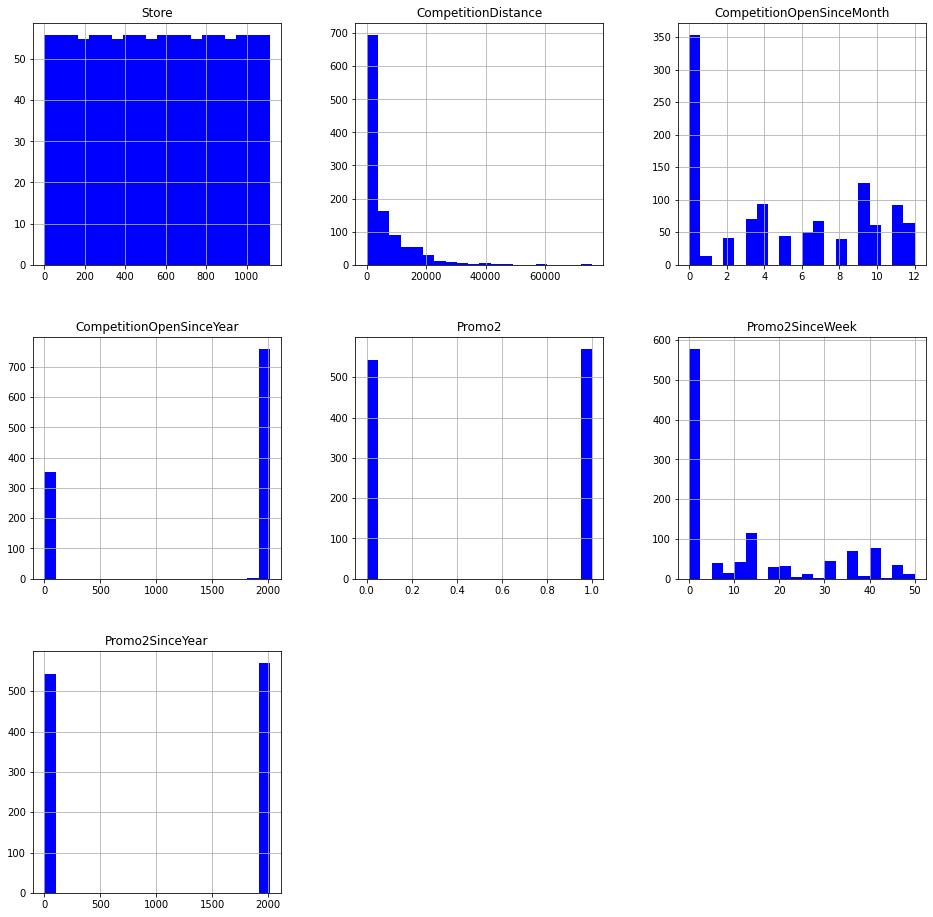

In [28]:
data_store.hist(bins=20, figsize=(16,16), color='b');

In [29]:
data_merged = pd.merge(data_train, data_store, how='inner', on='Store')
data_merged

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


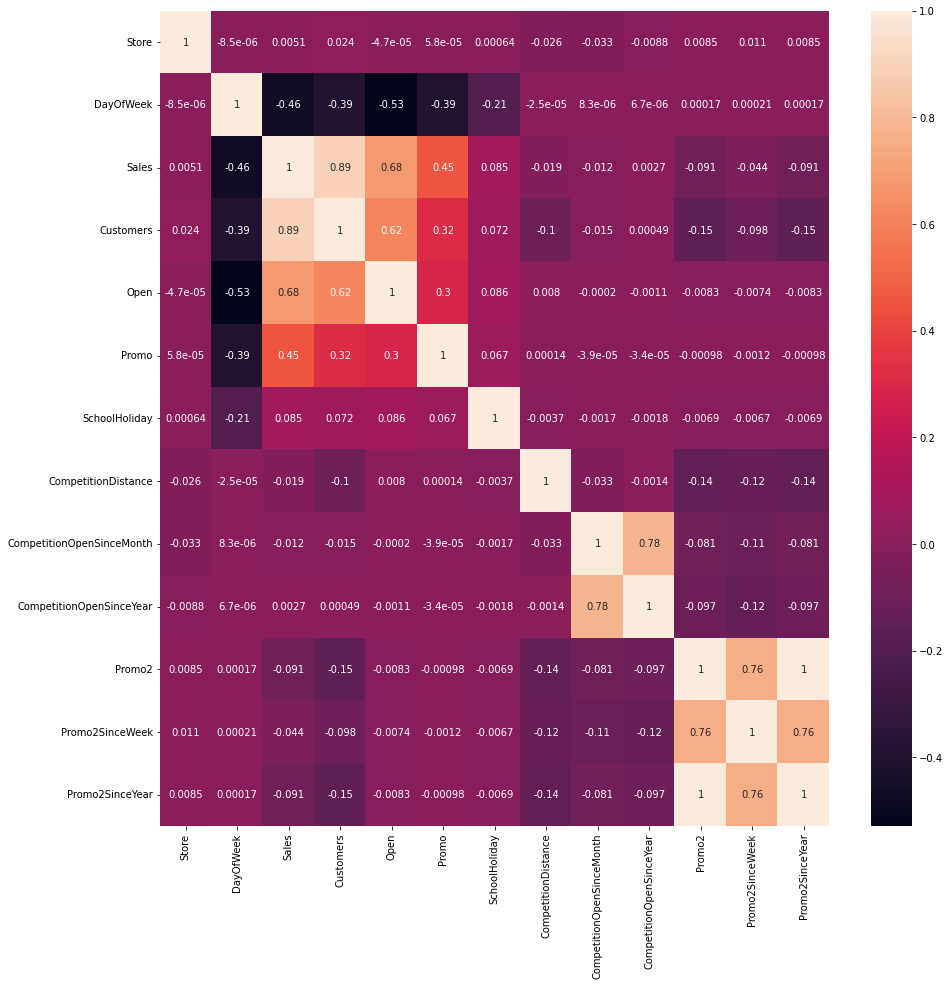

In [30]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data_merged.corr(), annot=True);

In [31]:
data_merged.corr().Sales.sort_values()

DayOfWeek                   -0.462125
Promo2SinceYear             -0.091056
Promo2                      -0.091040
Promo2SinceWeek             -0.044143
CompetitionDistance         -0.018869
CompetitionOpenSinceMonth   -0.012431
CompetitionOpenSinceYear     0.002749
Store                        0.005126
SchoolHoliday                0.085124
Promo                        0.452345
Open                         0.678472
Customers                    0.894711
Sales                        1.000000
Name: Sales, dtype: float64

In [32]:
data_merged.corr().Customers.sort_values()

DayOfWeek                   -0.386445
Promo2                      -0.150159
Promo2SinceYear             -0.150138
CompetitionDistance         -0.102362
Promo2SinceWeek             -0.098323
CompetitionOpenSinceMonth   -0.015188
CompetitionOpenSinceYear     0.000489
Store                        0.024325
SchoolHoliday                0.071568
Promo                        0.316169
Open                         0.616768
Sales                        0.894711
Customers                    1.000000
Name: Customers, dtype: float64

In [33]:
data_merged['year'] = pd.DatetimeIndex(data_merged['Date']).year
data_merged['month'] = pd.DatetimeIndex(data_merged['Date']).month
data_merged['day'] = pd.DatetimeIndex(data_merged['Date']).day

data_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


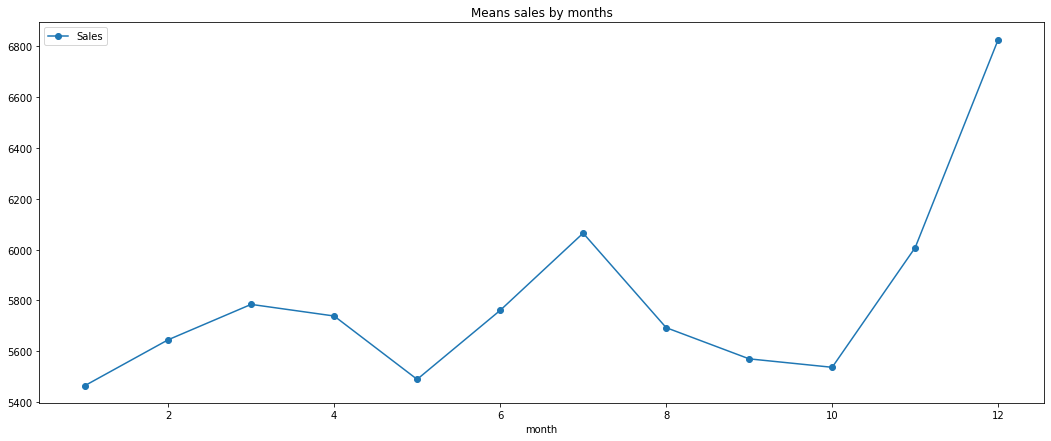

In [34]:
ax = data_merged.groupby('month')[['Sales']].mean().plot(figsize=(18,7), marker='o')
ax.set_title('Means sales by months');

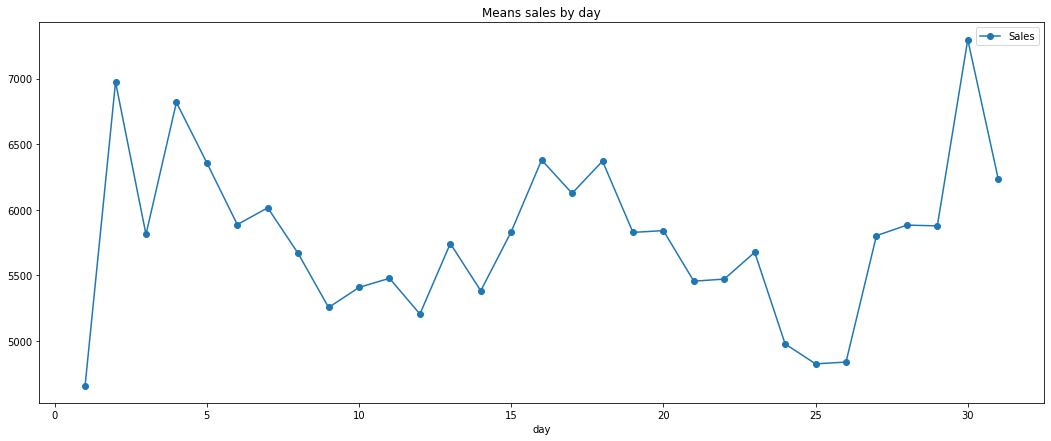

In [35]:
ax = data_merged.groupby('day')[['Sales']].mean().plot(figsize=(18,7), marker='o')
ax.set_title('Means sales by day');

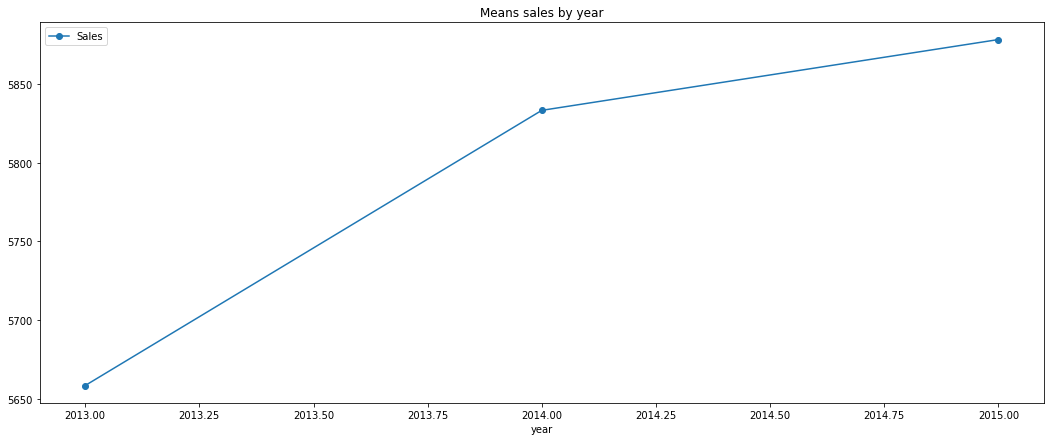

In [36]:
ax = data_merged.groupby('year')[['Sales']].mean().plot(figsize=(18,7), marker='o')
ax.set_title('Means sales by year');

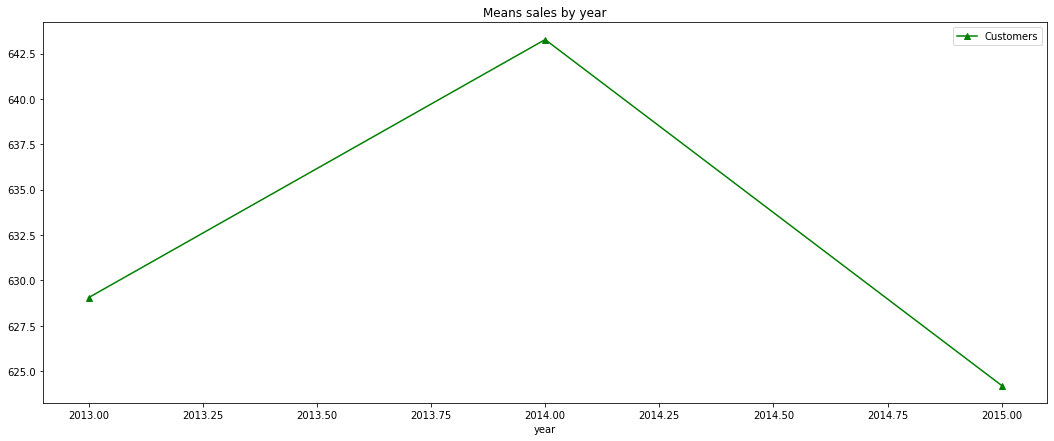

In [37]:
ax = data_merged.groupby('year')[['Customers']].mean().plot(figsize=(18,7), marker='^', color='g')
ax.set_title('Means sales by year');

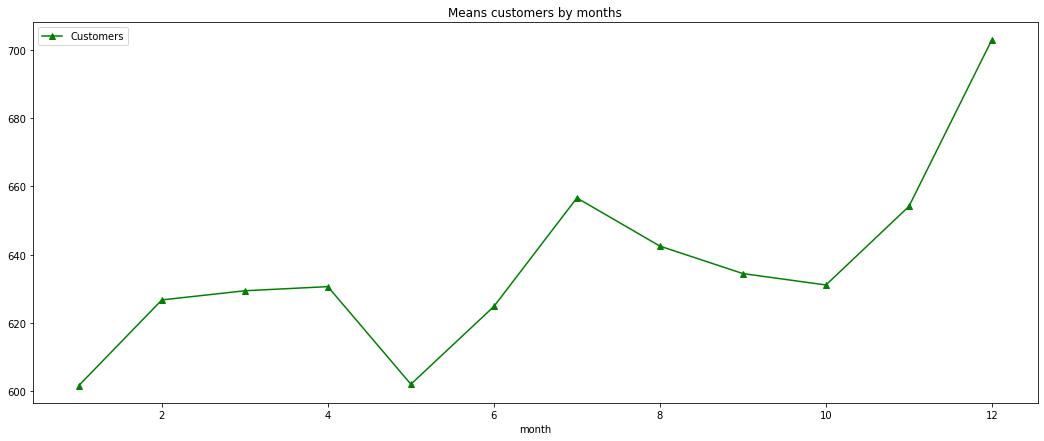

In [38]:
ax = data_merged.groupby('month')[['Customers']].mean().plot(figsize=(18,7), marker='^', color='g')
ax.set_title('Means customers by months');

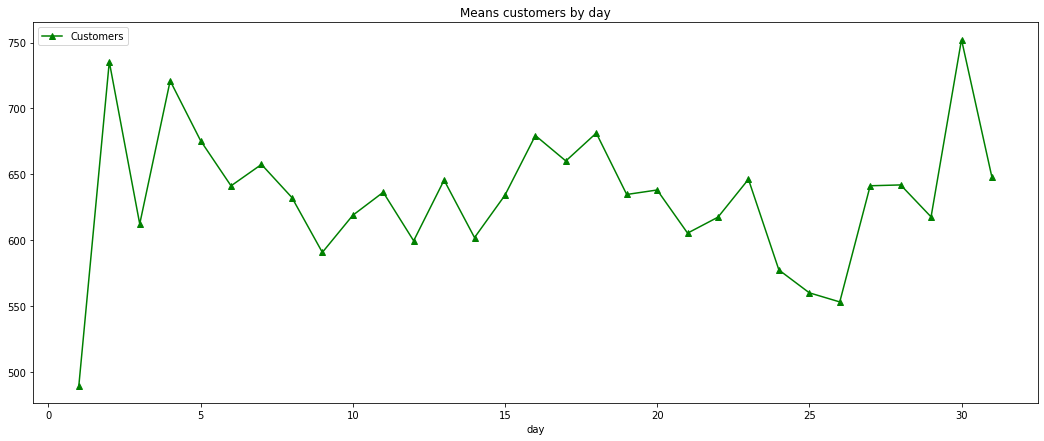

In [39]:
ax = data_merged.groupby('day')[['Customers']].mean().plot(figsize=(18,7), marker='^', color='g')
ax.set_title('Means customers by day');

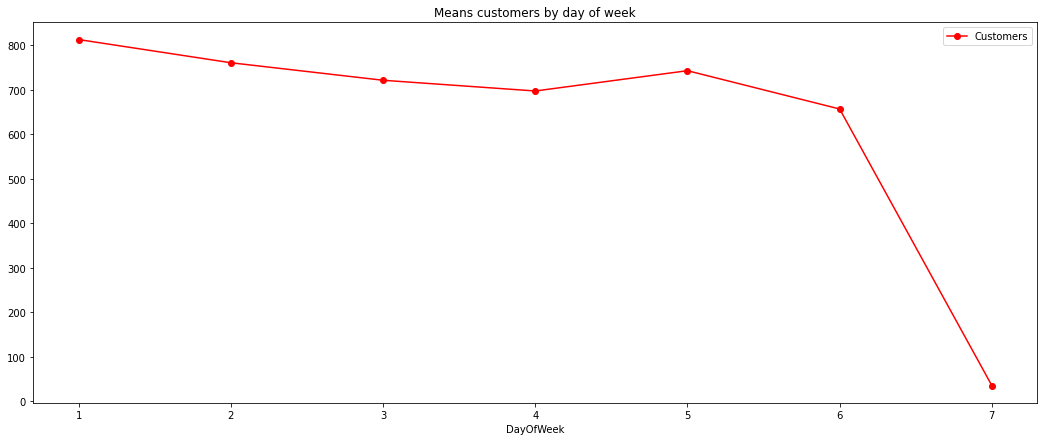

In [40]:
ax = data_merged.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(18,7), marker='o', color='r')
ax.set_title('Means customers by day of week');

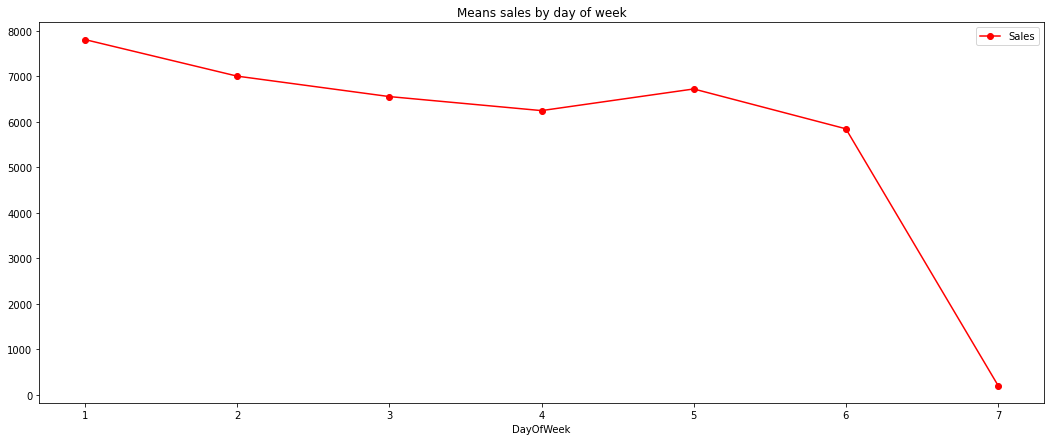

In [41]:
ax = data_merged.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(18,7), marker='o', color='r')
ax.set_title('Means sales by day of week');

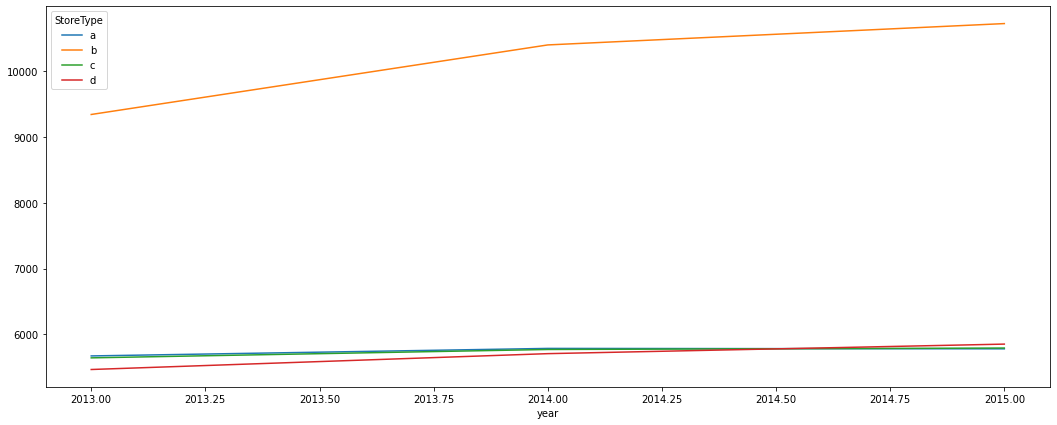

In [42]:
f, ax = plt.subplots(figsize=(18,7))
data_merged.groupby(['year', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax);

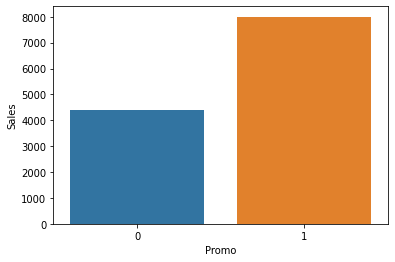

In [43]:
sns.barplot(x='Promo', y='Sales', data=data_merged);

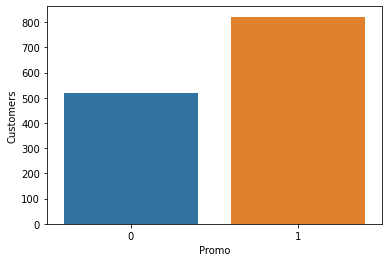

In [44]:
sns.barplot(x='Promo', y='Customers', data=data_merged);

In [49]:
# in fbprphet we need to change the columns names to 'ds' and 'y'
def sales_pred(store_id, df_sales, periods, holiday=None):
    df_sales = df_sales[df_sales['Store']==store_id]
    df_sales = df_sales[['Date', 'Sales']].rename(columns={'Date':'ds', 'Sales':'y'})
    df_sales = df_sales.sort_values(by='ds')
    
    model = Prophet(holidays=holiday)
    model.fit(df_sales)    
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    fig1 = model.plot(forecast, xlabel='Date', ylabel='Sales')
    fig2 = model.plot_components(forecast)

    return df_sales, forecast

In [50]:
# sales_pred(10, data_train, 60)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


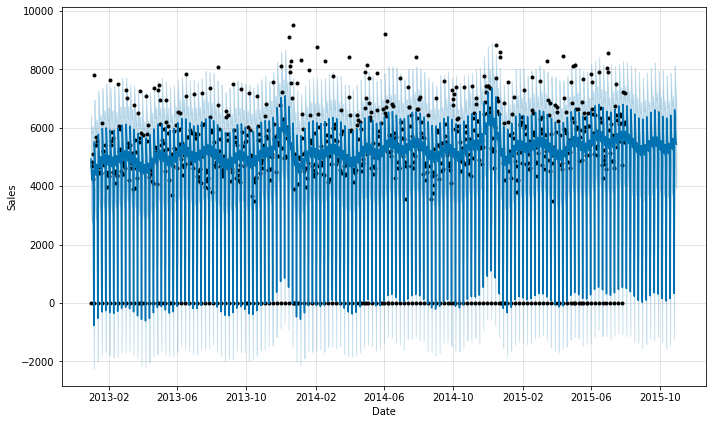

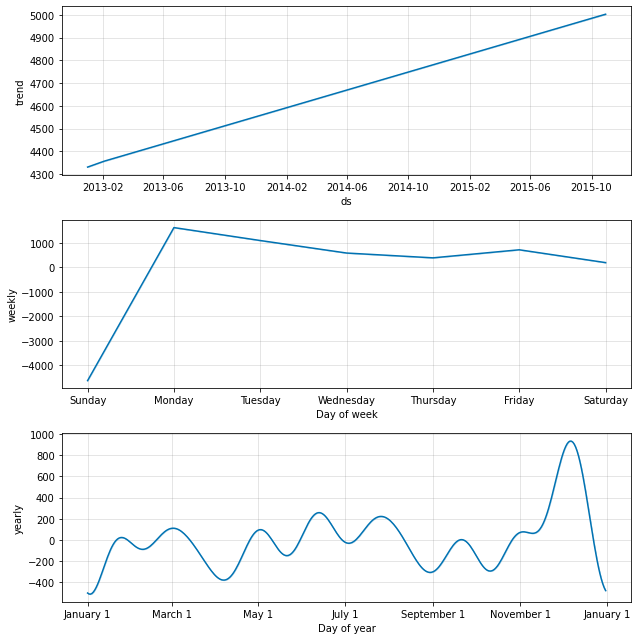

In [51]:
data_origin, data_pred = sales_pred(10, data_merged, 90)

In [52]:
# here we have the 15 day about predictions
data_pred.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1022,2015-10-20,4996.633501,4368.368768,7369.261530,4995.995004,4997.242450,931.723543,931.723543,931.723543,1101.082105,1101.082105,1101.082105,-169.358561,-169.358561,-169.358561,0.0,0.0,0.0,5928.357044
1023,2015-10-21,4997.280845,3924.885778,6961.576163,4996.633371,4997.901207,445.321440,445.321440,445.321440,589.100393,589.100393,589.100393,-143.778953,-143.778953,-143.778953,0.0,0.0,0.0,5442.602286
1024,2015-10-22,4997.928190,3706.102838,6768.788413,4997.265995,4998.560526,274.703188,274.703188,274.703188,392.345869,392.345869,392.345869,-117.642682,-117.642682,-117.642682,0.0,0.0,0.0,5272.631378
1025,2015-10-23,4998.575534,4110.181673,7098.866908,4997.900850,4999.216703,630.450115,630.450115,630.450115,721.964023,721.964023,721.964023,-91.513908,-91.513908,-91.513908,0.0,0.0,0.0,5629.025650
1026,2015-10-24,4999.222879,3639.294966,6708.712684,4998.536624,4999.874565,131.175816,131.175816,131.175816,197.119711,197.119711,197.119711,-65.943895,-65.943895,-65.943895,0.0,0.0,0.0,5130.398695
1027,2015-10-25,4999.870223,-1246.520785,1824.494146,4999.166773,5000.532195,-4673.536615,-4673.536615,-4673.536615,-4632.081673,-4632.081673,-4632.081673,-41.454942,-41.454942,-41.454942,0.0,0.0,0.0,326.333608
1028,2015-10-26,5000.517568,5090.548628,8130.386698,4999.799631,5001.197121,1611.944652,1611.944652,1611.944652,1630.469571,1630.469571,1630.469571,-18.524919,-18.524919,-18.524919,0.0,0.0,0.0,6612.462220
1029,2015-10-27,5001.164913,4637.837679,7637.517332,5000.431001,5001.864868,1103.509264,1103.509264,1103.509264,1101.082105,1101.082105,1101.082105,2.427159,2.427159,2.427159,0.0,0.0,0.0,6104.674176
1030,2015-10-28,5001.812257,4096.706899,7151.262097,5001.062969,5002.521382,610.154483,610.154483,610.154483,589.100393,589.100393,589.100393,21.054090,21.054090,21.054090,0.0,0.0,0.0,5611.966740
1031,2015-10-29,5002.459602,3927.125432,6895.993107,5001.698903,5003.177290,429.437475,429.437475,429.437475,392.345869,392.345869,392.345869,37.091605,37.091605,37.091605,0.0,0.0,0.0,5431.897076


In [53]:
data_merged.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
5,1,7,2015-07-26,0,0,0,0,0,0,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,26
6,1,6,2015-07-25,4364,500,1,0,0,0,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,25
7,1,5,2015-07-24,3706,459,1,0,0,0,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,24
8,1,4,2015-07-23,3769,503,1,0,0,0,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,23
9,1,3,2015-07-22,3464,463,1,0,0,0,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,22


In [54]:
school_holidays = data_merged[data_merged['SchoolHoliday'] == 1].loc[:, 'Date'].values
state_holidays = data_merged[(data_merged['StateHoliday'] == 'a') |
                             (data_merged['StateHoliday'] == 'b') |
                             (data_merged['StateHoliday'] == 'c')]\
                             .loc[:, 'Date'].values

In [55]:
state_holidays.shape, school_holidays.shape

((31050,), (181721,))

In [56]:
data_state_holiday = pd.DataFrame({'ds':pd.to_datetime(state_holidays),
                                   'holiday':'state_holiday'})
data_state_holiday

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
31045,2013-05-09,state_holiday
31046,2013-05-01,state_holiday
31047,2013-04-01,state_holiday
31048,2013-03-29,state_holiday


In [57]:
data_school_holiday = pd.DataFrame({'ds':pd.to_datetime(school_holidays),
                                   'holiday':'school_holiday'})
data_school_holiday

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday


In [58]:
data_school_state_holidays = pd.concat((data_state_holiday ,data_school_holiday))
data_school_state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(              ds     y
 9419  2013-01-01     0
 9418  2013-01-02  4812
 9417  2013-01-03  4675
 9416  2013-01-04  5114
 9415  2013-01-05  4256
 ...          ...   ...
 8482  2015-07-27  7212
 8481  2015-07-28  6140
 8480  2015-07-29  5524
 8479  2015-07-30  6186
 8478  2015-07-31  7185
 
 [942 rows x 2 columns],
             ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0   2013-01-01  4344.062890   613.163113  2936.529746  4344.062890   
 1   2013-01-02  4344.698126  3823.930528  6318.940069  4344.698126   
 2   2013-01-03  4345.333361  3837.725458  6284.469650  4345.333361   
 3   2013-01-04  4345.968597  4144.158376  6544.915214  4345.968597   
 4   2013-01-05  4346.603833  3440.434442  5914.865443  4346.603833   
 ..         ...          ...          ...          ...          ...   
 952 2015-08-11  4948.813590  4593.821137  7010.735296  4948.813590   
 953 2015-08-12  4949.448839  4044.177353  6423.426165  4949.448839   
 954 2015-08-13  4950.084089  4101.382082  662

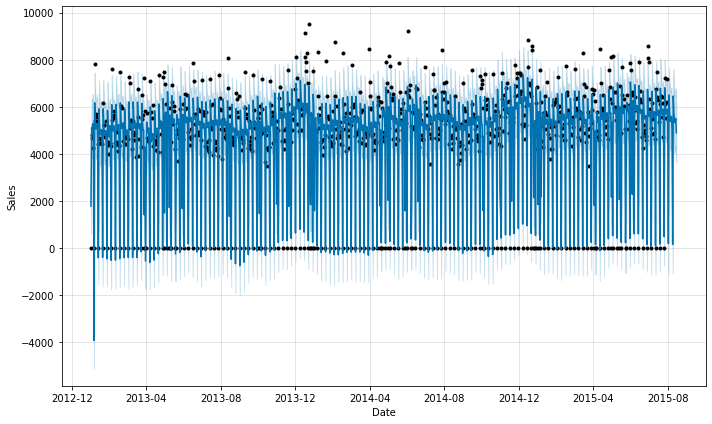

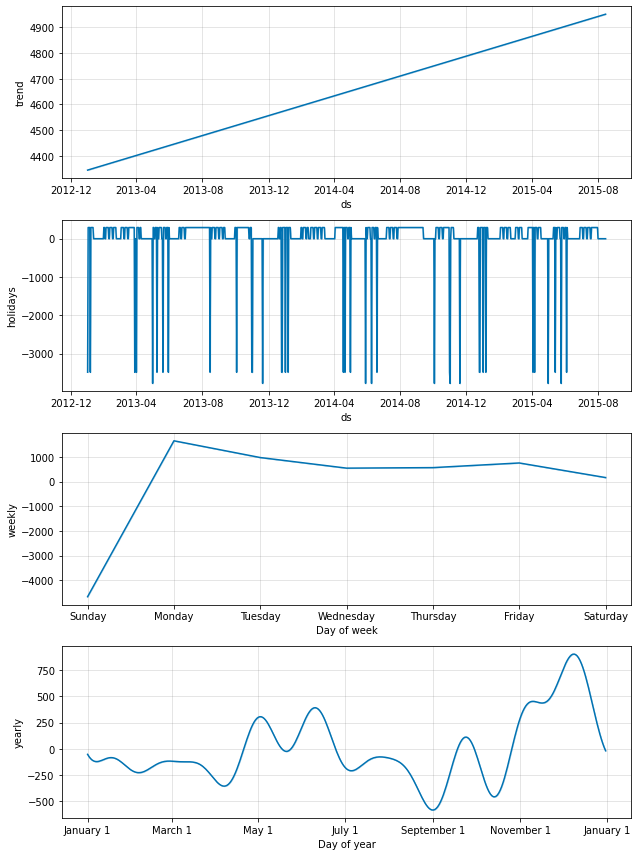

In [59]:
sales_pred(10, data_merged, 15, data_school_state_holidays)